# **Diamonds Price Prediction**
This notebook focuses on building a predictive regression model to estimate the sales price of diamonds based on their characteristics. The workflow includes preparing the data, selecting relevant features, and training machine learning models to achieve accurate predictions.

## CONTENTS
    1. Importing Libraries

    2. Data Loading and Preprocessing
        - Load data
        - Data Cleaning: 
            i)   Handle Duplicate and Missing Values
            ii)  Handle Inconsistent Categorical Data
            iii) Handle Outliers
        - Normalizing
        - Encoding
        - Feature Engineering

    3. Feature Selection

    4. Model Training

    5. Model Evaluation
    
    6. Visualization

## 1. Importing Libraries

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder
from sklearn.preprocessing import StandardScaler,RobustScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## 2. Data Loading and Preprocessing

In [63]:
# Data Loading
df = pd.read_csv('data/diamonds.csv')
df.head()

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.79,M,M,unknown,NaN,unknown,unknown,unknown,unknown,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,...,1.78,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.77,TN,M,unknown,NaN,unknown,unknown,unknown,unknown,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.78,M,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,...,1.82,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200


### Data Cleaning

#### i)Handle Duplicate and Missing Values

In [64]:
# Drop the first column
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,culet_size,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,N,...,1.79,M,M,unknown,NaN,unknown,unknown,unknown,unknown,200
1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,N,...,1.78,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,unknown,...,1.77,TN,M,unknown,NaN,unknown,unknown,unknown,unknown,200
3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,unknown,...,1.78,M,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,N,...,1.82,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200


In [65]:
# Check for missing values
df.isnull().sum()

cut                                 0
color                               0
clarity                             0
carat_weight                        0
cut_quality                         0
lab                                 0
symmetry                            0
polish                              0
eye_clean                           0
culet_size                          0
culet_condition                     0
depth_percent                       0
table_percent                       0
meas_length                         0
meas_width                          0
meas_depth                          0
girdle_min                          0
girdle_max                          0
fluor_color                         0
fluor_intensity                143491
fancy_color_dominant_color          0
fancy_color_secondary_color         0
fancy_color_overtone             1650
fancy_color_intensity               0
total_sales_price                   0
dtype: int64

In [66]:
# Fluorescence Intenity has a lot of missing values, so we can drop it
df.drop('fluor_intensity', axis=1, inplace=True)
# Replace NaN with 'unknown' in the remaining columns
df.replace(np.nan, 'unknown', inplace=True)

In [67]:
# Drop duplicate entries
print(df.duplicated().sum())
df.drop_duplicates(inplace=True, ignore_index=True)
df.shape

3911


(215792, 24)

#### ii) Handle Inconsistent Categorical Data

In [68]:
# Check for invalid data points
# 1. Diamonds with a color grade and a fancy color dominant color
display(df.loc[(df['color']!='unknown') & (df['fancy_color_dominant_color']!='unknown')])

# 2. Diamonds with a color grade and a fancy color overtone
display(df.loc[(df['color']!='unknown') & (df['fancy_color_overtone']!='unknown')])

# 3. Diamonds with an unknown color grade and an unknown fancy color dominant color
display(df.loc[(df['color']=='unknown') & (df['fancy_color_dominant_color']=='unknown')])

# 4. Diamonds of an invalid clarity grade i.e, SI3  
display(df.loc[(df['clarity']=='SI3')])

,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,culet_size,...,meas_width,meas_depth,girdle_min,girdle_max,fluor_color,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
7633,Round,M,VVS1,0.33,Excellent,GIA,Excellent,Excellent,unknown,unknown,...,4.49,2.72,unknown,unknown,Blue,Other,unknown,unknown,unknown,618
147126,Oval,M,VVS2,0.81,unknown,GIA,Very Good,Excellent,unknown,N,...,4.60,2.80,unknown,unknown,unknown,Other,unknown,unknown,unknown,3802


,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,culet_size,...,meas_width,meas_depth,girdle_min,girdle_max,fluor_color,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
9144,Round,K,VVS2,0.30,Excellent,GIA,Excellent,Excellent,unknown,unknown,...,4.29,2.68,unknown,unknown,unknown,unknown,unknown,Yellowish,unknown,624
149668,Pear,D,SI1,0.77,unknown,GIA,Very Good,Very Good,unknown,unknown,...,4.88,3.37,STK,XTK,unknown,unknown,unknown,Greenish,unknown,3882
151338,Pear,D,VS2,0.73,unknown,GIA,Very Good,Very Good,unknown,unknown,...,4.89,3.42,TK,XTK,unknown,unknown,unknown,Greenish,unknown,4119
157003,Round,K,VS2,1.10,Excellent,IGI,Excellent,Excellent,unknown,unknown,...,6.52,4.11,STK,STK,unknown,unknown,unknown,Brownish,unknown,4754
215310,Round,D,VVS2,5.05,Excellent,GIA,Excellent,Excellent,unknown,N,...,11.30,6.66,unknown,unknown,Blue,unknown,unknown,Yellowish,unknown,233311
215346,Round,E,VVS1,5.49,Excellent,GIA,Excellent,Excellent,unknown,N,...,11.32,6.95,unknown,unknown,Blue,unknown,unknown,Yellowish,unknown,245952


,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,culet_size,...,meas_width,meas_depth,girdle_min,girdle_max,fluor_color,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price


,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,culet_size,...,meas_width,meas_depth,girdle_min,girdle_max,fluor_color,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
128,Round,H,SI3,0.23,Very Good,IGI,Very Good,Very Good,unknown,unknown,...,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,284
147,Round,H,SI3,0.24,Very Good,IGI,Very Good,Very Good,unknown,unknown,...,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,296
169,Round,H,SI3,0.25,Very Good,IGI,Very Good,Very Good,unknown,unknown,...,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,308
210,Round,H,SI3,0.26,Very Good,IGI,Very Good,Very Good,unknown,unknown,...,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,320
226,Round,F,SI3,0.24,Very Good,IGI,Very Good,Very Good,unknown,unknown,...,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,324
290,Round,H,SI3,0.27,Very Good,IGI,Very Good,Very Good,unknown,unknown,...,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,334
390,Round,H,SI3,0.29,Very Good,IGI,Very Good,Very Good,unknown,unknown,...,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,358
9514,Round,G,SI3,0.30,Very Good,IGI,Very Good,Very Good,unknown,unknown,...,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,630
18972,Round,F,SI3,0.32,Very Good,IGI,Very Good,Very Good,unknown,unknown,...,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,720


In [69]:
# 1. Changing 'Other' value to unknown in fancy_color_dominant_color field
df['fancy_color_dominant_color'] = df['fancy_color_dominant_color'].replace('Other', 'unknown')

# 2. D, E, F are colorless diamonds, K, L, M are faint yellow diamonds so we can remove fancy color
# overtone for the colorless diamonds.
df.loc[(df['color']=='D') | (df['color']=='E'), 'fancy_color_overtone'] = 'unknown'

# 4. SI3 is not a valid clarity grade, it should be I1 
# https://beyond4cs.com/clarity/si3-grading/
df['clarity'] = df['clarity'].replace('SI3', 'I1')

In [ ]:
# Reduce the number of clarity grades to 5
def clarity_condition(clarity):
    if clarity in ['VVS1', 'VVS2']:
        return 'VVS'
    elif clarity in ['VS1', 'VS2']:
        return 'VS'
    elif clarity in ['SI1', 'SI2']:
        return 'SI'
    elif clarity in ['I1', 'I2', 'I3']:
        return 'I'
    elif clarity in ['IF']:
        return 'IF'
    else:
        return 'unknown'

# Reduce the number of color grades
def color_condition(color):
    if color in ['D', 'E', 'F']:
        return 'colorless'
    elif color in ['G', 'H', 'I', 'J']:
        return 'near colorless'
    elif color in ['K', 'L', 'M']:
        return 'faint color'
    else:
        return 'unknown'

df['clarity'] = df['clarity'].apply(clarity_condition)
df['color'] = df['color'].apply(color_condition)


In [71]:
categorical_columns = [x for x in df.columns if df[x].dtype == 'object']
numeric_columns = [x for x in df.columns if df[x].dtype != 'object']
print(len(categorical_columns))

17


#### iii) Handle Outliers

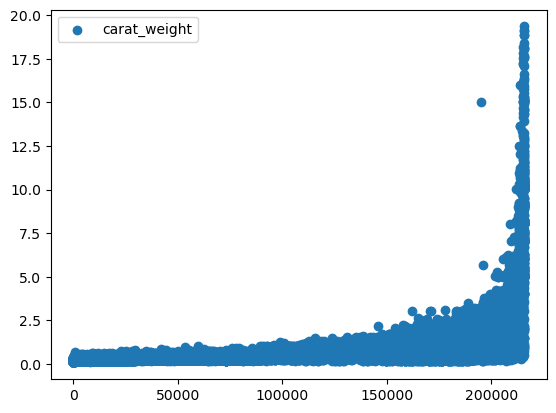

C:\Users\tsree\AppData\Local\Temp\ipykernel_32552\1178365760.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outliers_df = pd.concat([outliers_df, df.loc[(df[col]==0)]])


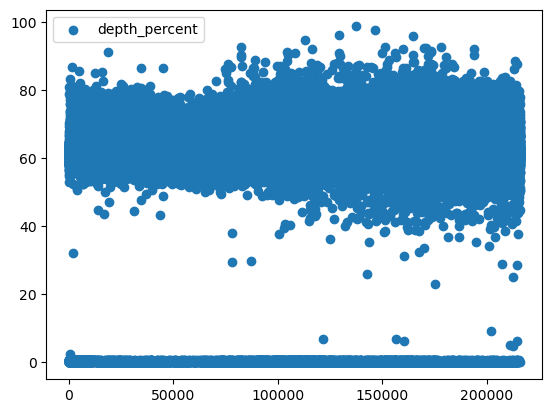

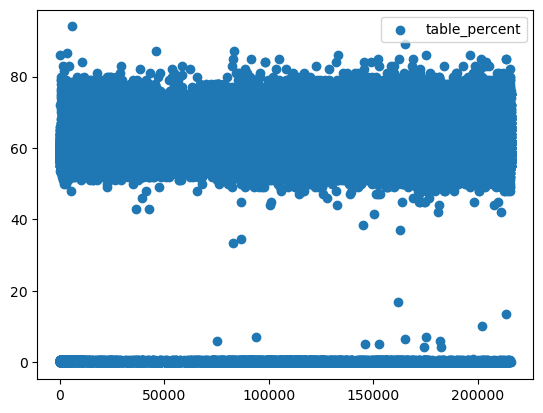

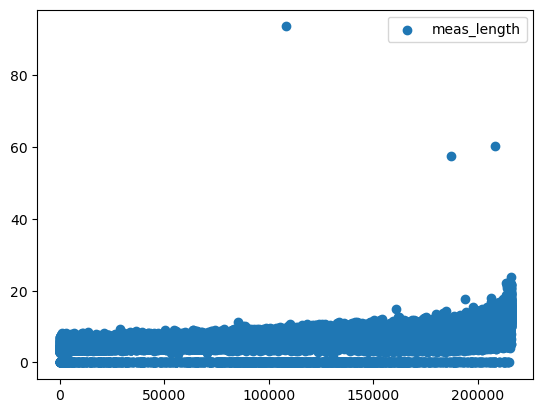

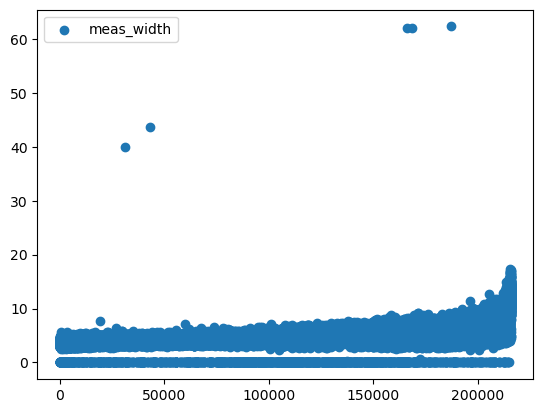

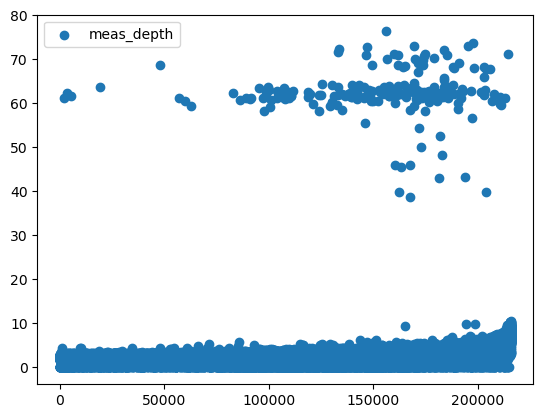

In [72]:
# Finding outliers
outliers_df = pd.DataFrame(columns=list(df))

for col in list(df):
    if df[col].dtypes == 'float64':
        # Add data points with a value of 0 for any numeric column to the outliers dataframe
        outliers_df = pd.concat([outliers_df, df.loc[(df[col]==0)]])
        plt.scatter(df.index, df[col], label=col) 
        plt.legend()
        plt.show() 

In [73]:
# Drop outliers from the above scatter plots
outliers_df = pd.concat([outliers_df, df.loc[(df['meas_depth']>30) | (df['meas_width']>30) | 
                (df['meas_length']>40) | (df['depth_percent']<20) | (df['table_percent']<20)]])
print(outliers_df.shape)

(17471, 24)


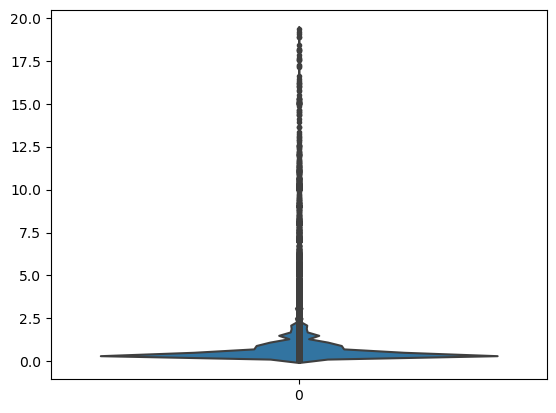

In [74]:
# Detect outliers of carat_weight
sns.violinplot(df['carat_weight'], inner='points', )
plt.show()

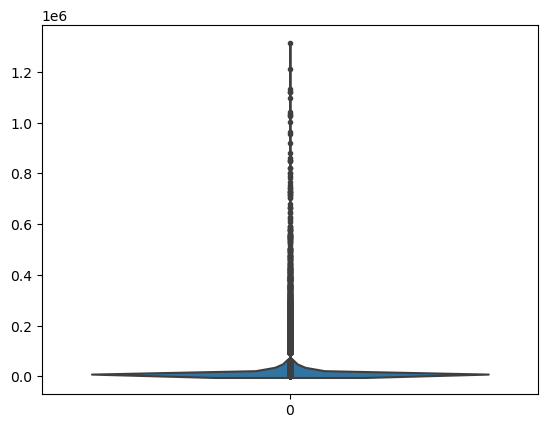

In [75]:
# Detect outliers of total_sales_price
# Since we know fancy color diamonds cost more, 
# we can find any colorless diamonds that are outliers
sns.violinplot(df.loc[(df['color']!='unknown')]['total_sales_price'], inner='points', )
plt.show()

In [76]:
# Drop outliers from the above plots
temp_df = df.loc[(df['color']!='unknown')]
outliers_df = pd.concat([outliers_df, temp_df.loc[(temp_df['carat_weight']>7.5)]])
print(outliers_df.shape)

df = df.drop(outliers_df.index).reset_index(drop=True)
print(df.shape)

(17848, 24)
(209114, 24)


In [77]:
df_original = df.copy()

In [78]:
# Save cleaned dataframe
df.to_pickle('data/modeling_cleaned.pkl')

### Normalizing

In [79]:
# Normalization using Robust Scaler
robust_scaler = RobustScaler()
df[numeric_columns] = robust_scaler.fit_transform(df[numeric_columns])
df.head()

# Normalization using Standard Scaler
# standard_scaler = StandardScaler(with_mean=False, with_std=True)
# df[numeric_columns] = standard_scaler.fit_transform(df[numeric_columns])
# df.head()

# Normalization using MinMax Scaler
# min_max_scaler = MinMaxScaler()
# df[numeric_columns] = min_max_scaler.fit_transform(df[numeric_columns])
# df.head()

,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,culet_size,...,meas_width,meas_depth,girdle_min,girdle_max,fluor_color,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,Round,colorless,VVS,-0.594203,Excellent,IGI,Very Good,Very Good,unknown,N,...,-1.378571,-1.275510,M,M,unknown,unknown,unknown,unknown,unknown,-0.400687
1,Round,colorless,VVS,-0.594203,Very Good,IGI,Very Good,Very Good,unknown,N,...,-1.364286,-1.285714,STK,STK,unknown,unknown,unknown,unknown,unknown,-0.400687
2,Round,colorless,VVS,-0.594203,Excellent,IGI,Very Good,Very Good,unknown,unknown,...,-1.357143,-1.295918,TN,M,unknown,unknown,unknown,unknown,unknown,-0.400687
3,Round,colorless,VVS,-0.594203,Excellent,IGI,Very Good,Very Good,unknown,unknown,...,-1.371429,-1.285714,M,STK,unknown,unknown,unknown,unknown,unknown,-0.400687
4,Round,colorless,VVS,-0.594203,Very Good,IGI,Very Good,Excellent,unknown,N,...,-1.407143,-1.244898,STK,STK,unknown,unknown,unknown,unknown,unknown,-0.400687


### Encoding

In [80]:
cat_values = pd.DataFrame(df[categorical_columns].apply(lambda x: x.unique().tolist()))
with pd.option_context('display.max_colwidth', 1):
    display(cat_values)

,0
cut,"[Round, Pear, Oval, Marquise, Princess, Emerald, Heart, Radiant, Cushion Modified, Cushion, Asscher]"
color,"[colorless, near colorless, faint color, unknown]"
clarity,"[VVS, VS, IF, SI, I]"
cut_quality,"[Excellent, Very Good, unknown, Good, Fair, Ideal]"
lab,"[IGI, GIA, HRD]"
symmetry,"[Very Good, Excellent, Good, Fair, Poor]"
polish,"[Very Good, Excellent, Good, Fair, Poor]"
eye_clean,"[unknown, Yes, E1, Borderline, No]"
culet_size,"[N, unknown, S, M, VS, L, EL, SL, VL]"
culet_condition,"[unknown, Abraded, Chipped, Pointed]"


In [81]:
# Reorder categorical columns for ordered encoding
ordered_columns = [ 'color', 'clarity','cut_quality', 'symmetry', 'polish', 'culet_size', 'fancy_color_intensity']
unordered_columns = [x for x in df.columns if x not in ordered_columns]

# cat_values.loc['color',0] = ['unknown','M','L','K','J','I','H','G','F','E','D']
cat_values.loc['color',0] = ['unknown', 'faint color', 'near colorless', 'colorless']

# cat_values.loc['clarity',0] = ['unknown','I3', 'I2', 'I1','SI3', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
cat_values.loc['clarity',0] = ['unknown', 'I', 'SI', 'VS', 'VVS', 'IF']

list1 = ['unknown', 'Poor','Fair', 'Good', 'Very Good', 'Excellent', 'Ideal']
cat_values.loc['cut_quality',0] = list1
cat_values.loc['symmetry',0] = list1
cat_values.loc['polish',0] = list1

cat_values.loc['eye_clean',0] = ['unknown', 'No', 'Borderline', 'E1', 'Yes']
cat_values.loc['culet_size',0] = ['unknown', 'N', 'VS', 'S', 'M', 'SL', 'L', 'VL', 'EL']

list2 = ['unknown', 'XTN', 'VTN', 'TN', 'STN', 'M', 'STK', 'TK', 'VTK', 'XTK']
cat_values.loc['girdle_min',0] = list2
cat_values.loc['girdle_max',0] = list2

cat_values.loc['fancy_color_intensity',0] = ['unknown', 'Faint', 'Very Light', 'Light', 'Fancy Light', 'Fancy', 'Fancy Intense', 'Fancy Vivid', 'Fancy Dark', 'Fancy Deep']

In [82]:
# Ordinal Encoding
enc = OrdinalEncoder(categories=cat_values[0][ordered_columns].to_list())
enc.fit(df[ordered_columns])
df[ordered_columns] = enc.transform(df[ordered_columns])

In [83]:
# Label Encoding
le = LabelEncoder()
df[unordered_columns] = df[unordered_columns].apply(le.fit_transform)
df.head()

,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,culet_size,...,meas_width,meas_depth,girdle_min,girdle_max,fluor_color,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,10,3.0,4.0,1,5.0,2,4.0,4.0,4,1.0,...,35,28,0,0,5,11,10,7,0.0,0
1,10,3.0,4.0,1,4.0,2,4.0,4.0,4,1.0,...,37,27,1,1,5,11,10,7,0.0,0
2,10,3.0,4.0,1,5.0,2,4.0,4.0,4,0.0,...,38,26,4,0,5,11,10,7,0.0,0
3,10,3.0,4.0,1,5.0,2,4.0,4.0,4,0.0,...,36,27,0,1,5,11,10,7,0.0,0
4,10,3.0,4.0,1,4.0,2,4.0,5.0,4,1.0,...,31,31,1,1,5,11,10,7,0.0,0


### Feature Engineering

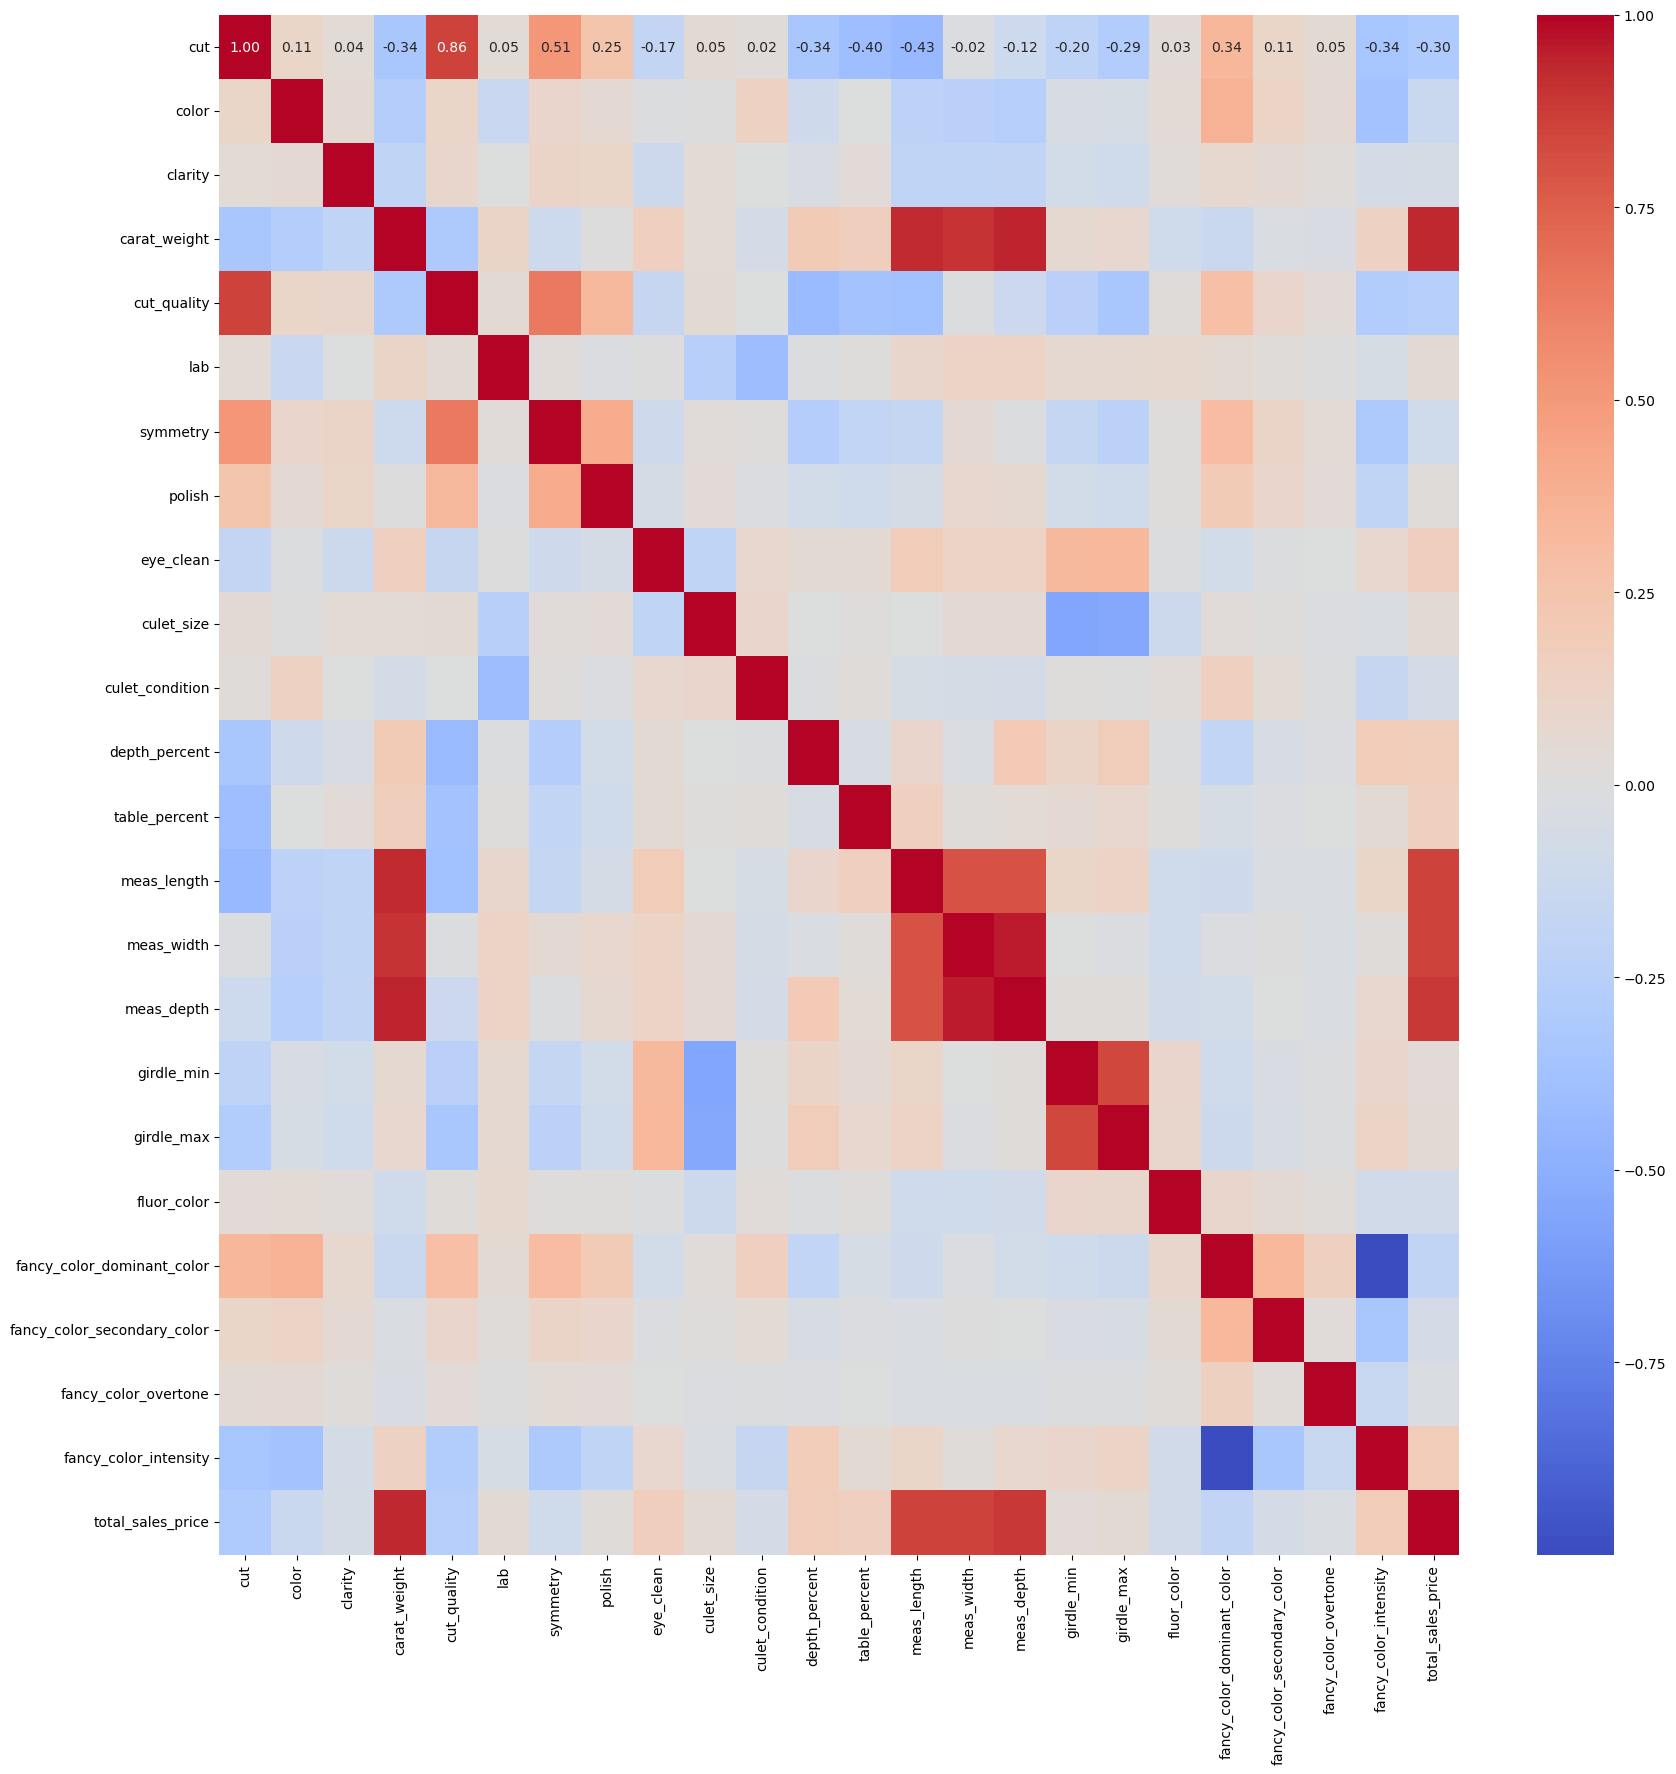

In [84]:
# Correlation Analysis
df = df.sample(frac=1).reset_index(drop=True)
corr = df.corr(method='spearman')
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [85]:
# Selecting features
k = 15
features = corr['total_sales_price'].abs().sort_values(ascending=False)
print(features)

top_features = features.index[:k]

total_sales_price              1.000000
carat_weight                   0.929750
meas_depth                     0.885955
meas_length                    0.857401
meas_width                     0.854503
cut                            0.303023
cut_quality                    0.262575
fancy_color_intensity          0.192572
fancy_color_dominant_color     0.192572
depth_percent                  0.172099
eye_clean                      0.164626
table_percent                  0.160211
color                          0.139009
symmetry                       0.094852
fluor_color                    0.092892
fancy_color_secondary_color    0.067274
culet_condition                0.062313
clarity                        0.056460
lab                            0.052381
girdle_max                     0.051819
culet_size                     0.048164
girdle_min                     0.038407
fancy_color_overtone           0.029346
polish                         0.023551
Name: total_sales_price, dtype: float64


### Splitting Data

In [86]:
# Sample the data with top 10 features
df_top_features = df[top_features]
df_sample = df_top_features.sample(frac=0.9, random_state=42)
df_sample = df_sample.reset_index(drop=True)

# Split the data into train and test sets
X_sample, y_sample = df_sample.drop('total_sales_price', axis=1), df_sample['total_sales_price']
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42, shuffle=True)

## Model Training

### i) Multiple Linear Regression

In [87]:
from sklearn.linear_model import LinearRegression

# create linear regression object
regr = LinearRegression()
# train the model using the training sets
regr.fit(X_train, y_train)
# predict output using test set
y_pred = regr.predict(X_test)


In [88]:
from sklearn.metrics import mean_squared_error, r2_score,\
      mean_absolute_error

# evaluate the model
# y_test=y_test.to_numpy()
n = y_test.shape[0]

print('Coefficients: \n', regr.coef_)
print('Mean Absolute Error: %.2f' % mean_absolute_error(y_test, y_pred))
print('Root Mean Squared Error: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred)))
print('Coefficient of Determination(R2 score): %.4f' % r2_score(y_test, y_pred))
# print('Relative Absolute Error: %.4f' % relative_absolute_error(y_test, y_pred))
# adjusted r-squared
adj_r2 = 1 - (1 - r2_score(y_test, y_pred)) * (n - 1) / (n - X_test.shape[1] - 1)
print('Adjusted R-squared: %.4f' % (adj_r2))

Coefficients: 
 [  34.31054527    1.96133705    3.95028073    8.7950921   -54.1453182
  122.10896418  538.99348299 -468.19182941    4.4685553    17.25075835
    5.40979599  856.9202833   254.26818207   11.30006405]
Mean Absolute Error: 1038.05
Root Mean Squared Error: 1690.65
Coefficient of Determination(R2 score): 0.8549
Adjusted R-squared: 0.8549


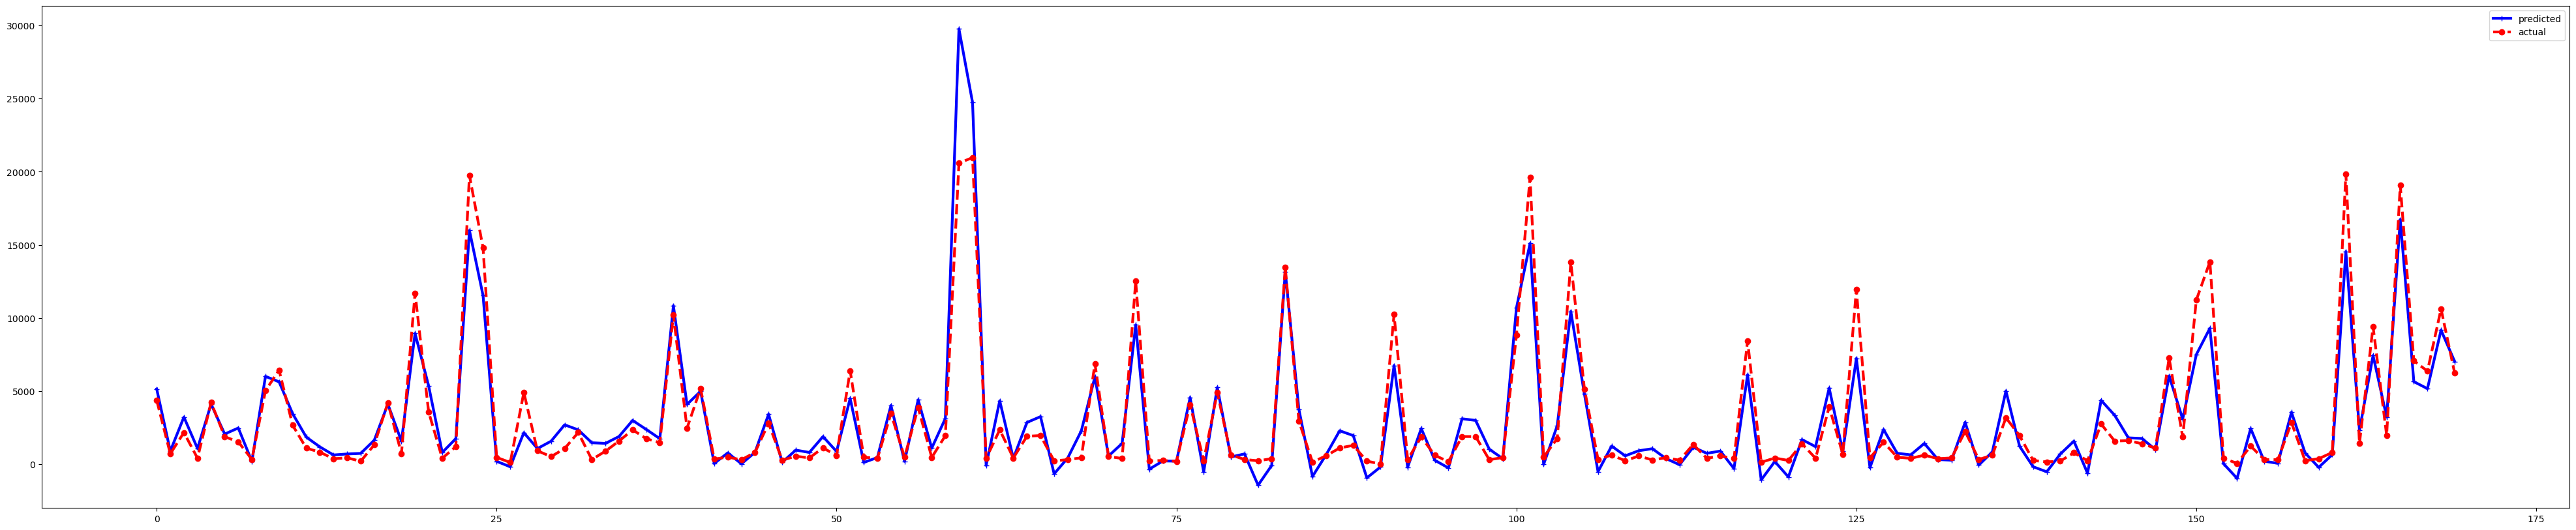

In [89]:
# plot the fit
y_pred = y_pred.reshape(y_test.shape[0], 1)
y_test = y_test.to_numpy().reshape(y_test.shape[0], 1)
plt.figure(figsize=(50,10))
plt.plot(y_pred[3100:3270], 'b+-', label='predicted', linewidth=3)
plt.plot(y_test[3100:3270],'ro--',label='actual', linewidth=3)

plt.legend()
plt.show()


### ib) MLR with Ridge Pipelines

In [90]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.feature_selection import SelectKBest, f_regression

linear_reg_pipe = make_pipeline(
    SelectKBest(score_func=f_regression, k=10), 
    LinearRegression()).set_output(transform="pandas")

cv_results = cross_validate(linear_reg_pipe,
                            X_train, 
                            y_train, 
                            cv=5, 
                            scoring='neg_mean_absolute_error', 
                            return_train_score=True,
                            return_estimator=True)

In [91]:
train_error = cv_results['train_score']
test_error = cv_results['test_score']

print(f'Train Error: {train_error.mean()} +/- {train_error.std()}')
print(f'Test Error: {test_error.mean()} +/- {test_error.std()}')

Train Error: -1032.6953714924857 +/- 2.424609255959569
Test Error: -1032.8649675936294 +/- 6.109496488627776


In [92]:
ridge = make_pipeline(
    SelectKBest(score_func=f_regression, k=15), 
    StandardScaler(),
    Ridge(alpha=100, solver='cholesky')).set_output(transform="pandas")

cv_results = cross_validate(linear_reg_pipe,
                            X_train, 
                            y_train, 
                            cv=5, 
                            scoring='neg_mean_absolute_error', 
                            return_train_score=True,
                            return_estimator=True)

In [93]:
train_error = cv_results['train_score']
test_error = cv_results['test_score']

print(f'Train Error: {train_error.mean()} +/- {train_error.std()}')
print(f'Test Error: {test_error.mean()} +/- {test_error.std()}')

Train Error: -1032.6953714924857 +/- 2.424609255959569
Test Error: -1032.8649675936294 +/- 6.109496488627776


### ii) ANN 